# Unet Implementation

In [1]:
import pickle
import gzip
import numpy as np
import os
import time
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/richard/miniconda3/envs/pytcu10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### Helper functions

In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
        
def flatten(dicts):
    
    # extract the annotated video frames, their labels
    # and the boxes
    
    images = []
    boxes = []
    labels = []
    
    for i, dic in enumerate(dicts):
        
        video = dic['video']
        frames = dic['frames']
        dic_labels = dic['label']
        
        images.append((video[:,:,frames[0]] / 255).astype('float32'))
        images.append((video[:,:,frames[1]] / 255).astype('float32'))
        images.append((video[:,:,frames[2]] / 255).astype('float32'))
        
        labels.append(dic_labels[:,:,frames[0]].astype('float32'))
        labels.append(dic_labels[:,:,frames[1]].astype('float32'))
        labels.append(dic_labels[:,:,frames[2]].astype('float32'))
        
    return images, labels

class SegDataset(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.labels[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

### Load data

In [5]:
# load data
train_data = load_zipped_pickle("data/train.pkl")
test_data = load_zipped_pickle("data/test.pkl")

In [6]:
size = (128, 128)

### Preprocessing

In [7]:
# turn dictionaries into lists of images and labels
images, labels = flatten(train_data)
# last 19 are expert images, take 6 of them to form validation dataset
train_images, train_labels = images[:177], labels[:177]
val_images, val_labels = images[177:], labels[177:]

### Augmentation

In [44]:
train_transform = A.Compose(
    [
        A.Resize(128, 128),
        ToTensorV2()
    ]
)
val_transform = A.Compose(
    [
        A.Resize(128, 128),
        ToTensorV2()
    ]
)

In [45]:
train_dataset = SegDataset(train_images, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, pin_memory=True)
val_dataset = SegDataset(val_images, val_labels, train_transform)
val_loader = DataLoader(val_dataset, batch_size=6, pin_memory=True)

### Model

In [47]:
class Unet(nn.Module):
    
    def __init__(self, filters=64):
        
        super().__init__()
        
        # following advice of the TA, first only with 3 encoder
        # and 3 decoder blocks instead of 4 as in the paper
        
        self.max_pool = nn.MaxPool2d(2)
        
        self.block_enc_1 = self.conv_block(1, filters)
        self.block_enc_2 = self.conv_block(filters, 2*filters)
        self.block_enc_3 = self.conv_block(2*filters, 4*filters)
        
        self.block_inbetween = self.conv_block(4*filters, 8*filters, True)
        
        self.block_dec_1 = self.conv_block(8*filters, 4*filters, True)
        self.block_dec_2 = self.conv_block(4*filters, 2*filters, True)
        
        self.block_last = self.conv_block(2*filters, filters, True, True)
        
    def conv_block(self, channels, filters, dec=False, last=False):
        
        modules = []
        
        modules.append(nn.Conv2d(channels, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())
        modules.append(nn.Conv2d(filters, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())
        
        # if not decoder, then we add upscaling layer
        # if last layer, then we add conv 1x1 and sigmoid to get logits in (0, 1)
        if dec:
            if not last:
                modules.append(nn.ConvTranspose2d(filters, filters//2, 2, stride=(2,2)))
            else:
                modules.append(nn.Conv2d(filters, 1, 1, 1))
                modules.append(nn.Sigmoid())
            
        return nn.Sequential(*modules)
            
    def forward(self, x):
        
        # encoder
        
        x1 = self.block_enc_1(x)
        x2 = self.max_pool(x1)
        
        x3 = self.block_enc_2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.block_enc_3(x4)
        x6 = self.max_pool(x5)
        
        # between encoder and decoder
        
        x7 = self.block_inbetween(x6)
        
        # decoder
        
        x8 = self.block_dec_1(torch.cat((x7, x5), dim=1))
        x9 = self.block_dec_2(torch.cat((x8, x3), dim=1))
        
        x10 = self.block_last(torch.cat((x9, x1), dim=1))
        
        return x10

### Train

In [48]:
def iou_metric(inputs, targets):       
        
        # remove channel dimension (C = 1) with squeeze
        inputs = inputs.squeeze()
        
        # round to 0 or 1
        inputs = torch.round(inputs)
        
        # get intersection and union
        intersection = (inputs * targets).sum(dim=(1, 2))
        total = (inputs + targets).sum(dim=(1, 2))
        union = total - intersection 
        
        IoU = intersection / union
                
        return IoU

In [49]:
def evaluate(model, val_loader):
    
    val_iou_list = torch.Tensor().to(device)
    
    for x,y in val_loader:
        
        x,y = x.to(device), y.to(device)
        output = unet(x)
        val_iou_list = torch.cat((val_iou_list, iou_metric(output, y)))
    
    return torch.median(val_iou_list)

In [52]:
unet = Unet(filters=16).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-4)
criterion = smp.losses.JaccardLoss(mode='binary')

### Train Loop

In [54]:
for epoch in range(100):
    
    t = time.time()
    num_samples_epoch = 0
    train_loss_cum = 0
    train_iou_list = torch.Tensor().to(device)
    
    for x,y in train_loader:
        
        x,y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        unet.train()
        
        output = unet(x)
        loss = criterion(output.squeeze(), y.squeeze())
        
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        num_samples_epoch += x.shape[0]
        train_loss_cum += loss * x.shape[0]
        
        # calculate train IoU scores and concat
        unet.eval()
        with torch.no_grad():
            train_iou_list = torch.cat((train_iou_list, iou_metric(output, y)))
    
    # get median IoU on validation data
    with torch.no_grad():
        val_iou = evaluate(unet, val_loader)
            
    # average train_loss
    train_loss = train_loss_cum / num_samples_epoch
    
    # get median IoU on train data
    train_iou = torch.median(train_iou_list)   
    
    epoch_duration = time.time() - t

    print(f'Epoch {epoch} | Train IoU: {train_iou:.4f} | '
          f'Train loss: {train_loss:.4f} | '
          f' Validation IoU: {val_iou:.4f} | '
          f' Duration {epoch_duration:.2f} sec')

tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
tensor(0.9999) tensor(0.)
tensor(1.) tensor(0.)


KeyboardInterrupt: 

### Visualizing some results

In [ ]:
# shows summary of model like in tensorflow
summary = summary(unet, (1, 128, 128))

In [15]:
unet = unet.to('cpu')
X_vis = train_images[:5]
y_vis = train_labels[:5]
res = unet(torch.from_numpy(X_vis))

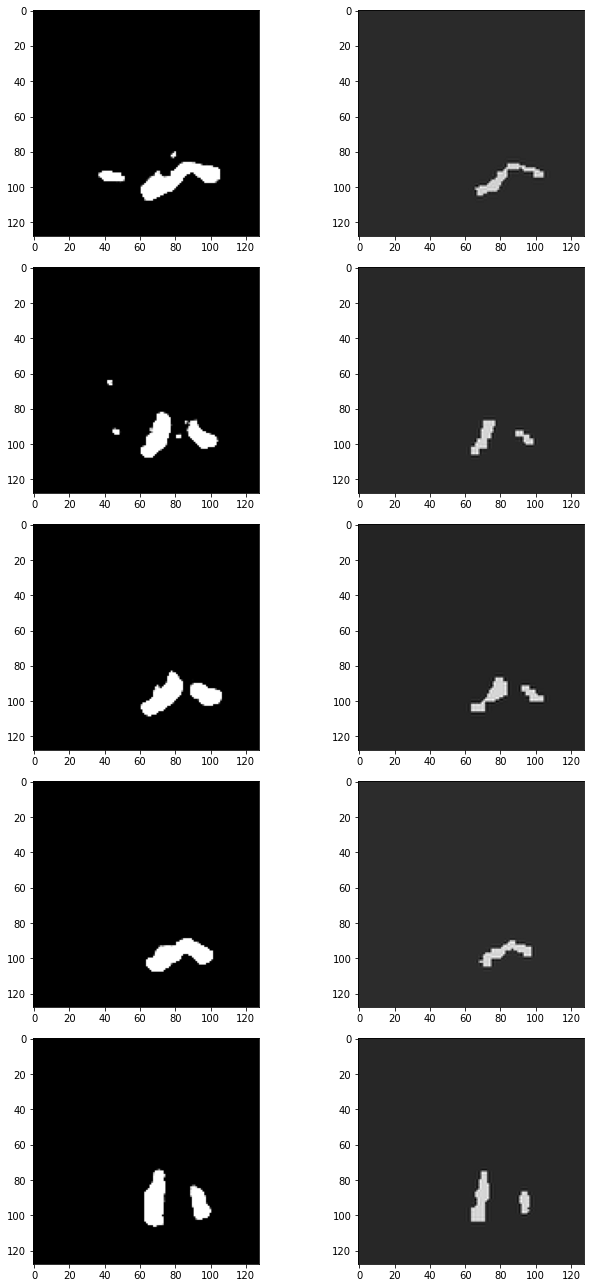

In [16]:
fig, ax = plt.subplots(5,3)
fig.set_figheight(18)
fig.set_figwidth(10)
for i in range(res.shape[0]):
    
    ax[i,0].imshow(res[i].squeeze().cpu().detach().numpy(), cmap='gray')
    ax[i,1].imshow(y_vis[i].squeeze().cpu().detach().numpy(), cmap='gray')
    ax[i,1].imshow(y_vis[i].squeeze().cpu().detach().numpy(), cmap='gray')
plt.tight_layout()